# Wrangling NHANES Data

## Summary

In this notebook we take a look at the quality of the data. We examine the missing values that must be imputed, and dropping rows and columns. We also consider special columns we use toward feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("preprocessed_data.pkl")

In [3]:
n,m = df.shape

print(f'The dataframe consists of {n} rows and {m} columns.')

The dataframe consists of 32515 rows and 56 columns.


## View missing data by column

In [4]:
def col_frac_missing(df, threshold = 0.05):
    fraction_null = df.isnull().sum()/len(df)
    plt.figure(figsize=(16,8))
    plt.xticks(np.arange(len(fraction_null)),fraction_null.index,rotation='vertical')
    plt.ylabel('fraction of rows with missing data')
    plt.bar(np.arange(len(fraction_null)),fraction_null)
    plt.axhline(2*threshold,linewidth=2, color='r')
    plt.axhline(threshold,linewidth=2, color='g')
    plt.show()
    return fraction_null

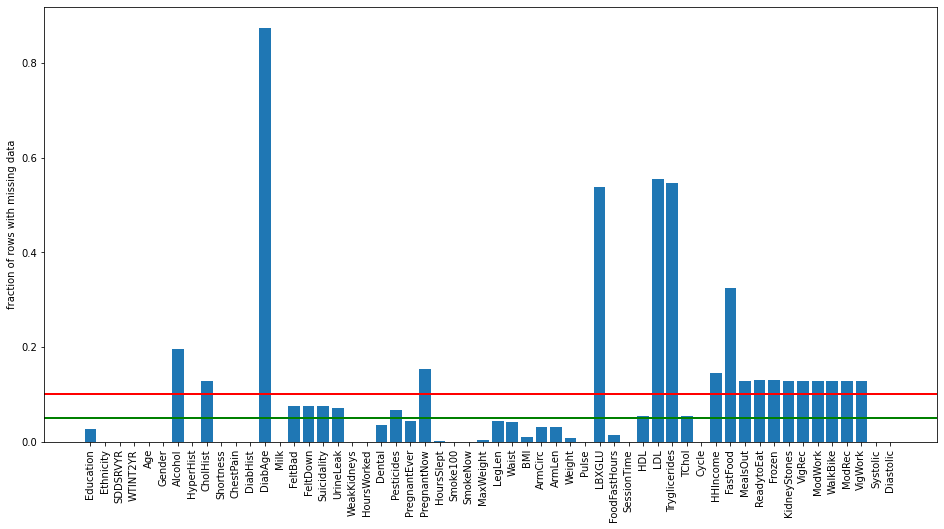

In [5]:
column_fraction_null = col_frac_missing(df,threshold = 0.05)

We can see quite a few columns have missing data over the 5% and 10% threshold. There is a stand out column DiabAge -- the age a person is diagnosed with diabetes -- but of course if someone is never diagnosed this value is missing by design. Therefore we must come back to this column later. Next we will attempt to drop rows missing the most values.

## View missing data by row

<AxesSubplot:>

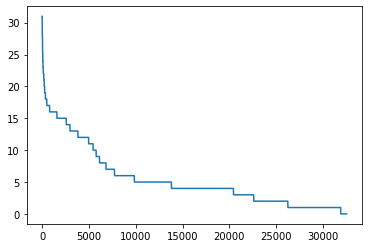

In [6]:
frac_index_null = df.isnull().sum(1).sort_values(ascending = False)

frac_index_null.reset_index()[0].plot()

There seem to be roughly 5000 SPs missing well over 5 values. We will investigate whether dropping such rows improves the missing data by columns.

In [7]:
# Drop SPs missing 5 or more values
df_depleted = df[df.isnull().sum(1)<5]

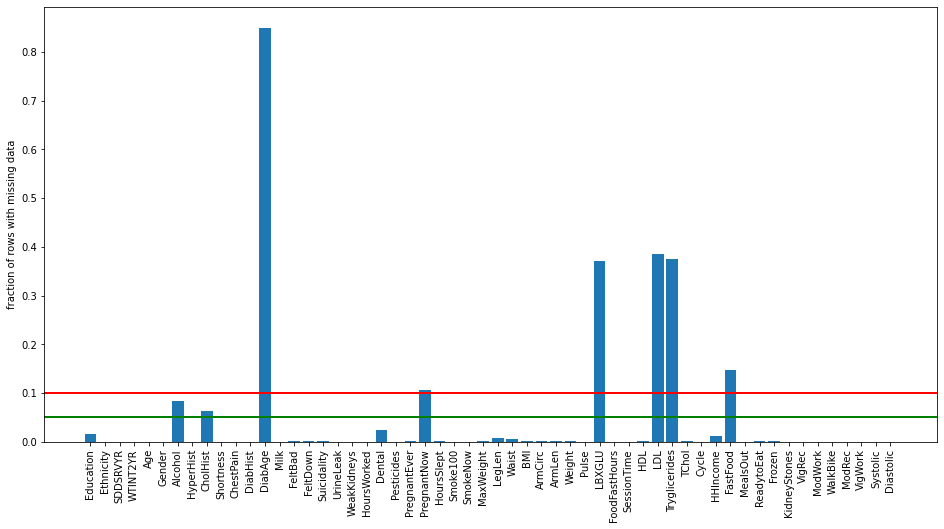

In [8]:
column_fraction_null = col_frac_missing(df_depleted)

We can see LBXGLU, LDL, Triglicerides miss very large number of values. These columns are not part of our predictive analysis, but will be used in exploratory analysis, so we will leave it in for now. FastFood and and PregnantNow are still missing a large numbe of values, so we will drop them from the original dataframe.

## Drop columns with many missing values

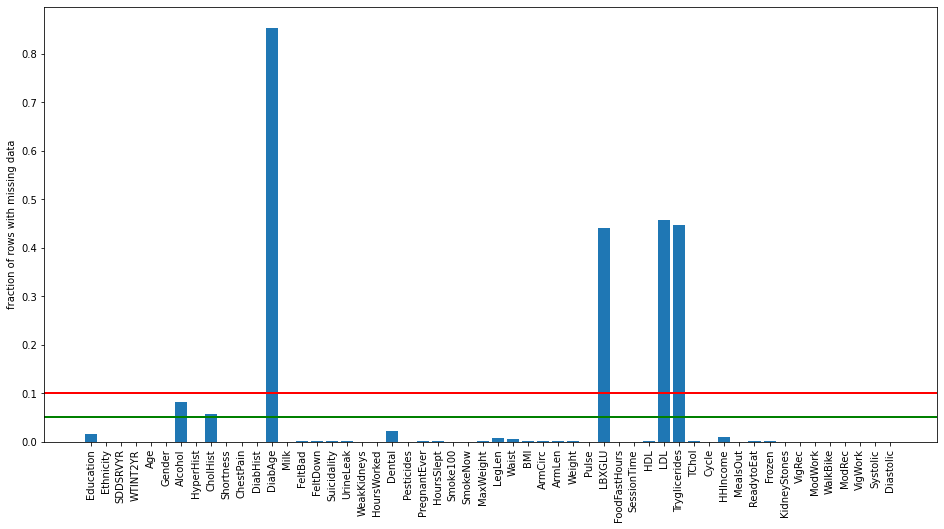

In [9]:
# Drop columns from original dataframe missing many values
df.drop(['PregnantNow','FastFood'],axis=1,inplace=True)
# Drop SPs missing 5 or more values
df_depleted = df[df.isnull().sum(1)<5].copy()
column_fraction_null = col_frac_missing(df_depleted)

The columns Alcohol and CholHist still seem to be missing a high number of values. Let us view the portion missing for these columns.

In [10]:
print('Portion missing:')
column_fraction_null.loc[['Alcohol','CholHist']]

Portion missing:


Alcohol     0.081825
CholHist    0.056164
dtype: float64

Alcohol is missing a high number of values at 8.2%, unfortunately there is not a similar feature so it would be a better not to remove it. CholHist (Whether a doctor has told you you have high cholesterol) likely correlates well with HyperHist (Whether a doctor has told you you have hypertension). Let us view the correlation.

In [11]:
HHvsCH = df_depleted[['HyperHist','CholHist']].dropna()
tab = pd.crosstab(HHvsCH['HyperHist'] == 1, HHvsCH['CholHist'] == 1) 
tab

CholHist,False,True
HyperHist,,
False,8929,3233
True,3343,4577


Although the correlation appears high, the missing values are only borderline, so we will keep the feature.

## Fixing the DiabAge variable

In [12]:
x = df['DiabHist'].value_counts()
print(f'SPs not told they have diabetes: {x[0.0]}')
print(f'SPs told they have diabetes: {x[1.0]}')

SPs not told they have diabetes: 27704
SPs told they have diabetes: 4811


The majority of SPs have not been diagnosed with diabetes, which explains the large number of missing values in DiabAge. We will construct a new feature DiabHistAge which combines these two variables.

In [13]:
df_depleted['DiabHistAge'] = 0
df_depleted.loc[(df_depleted['DiabAge'] > 50),'DiabHistAge'] = 1
df_depleted.loc[(df_depleted['DiabAge'] > 50),'DiabHistAge'] = 2
df_depleted.drop(['DiabHist','DiabAge'],axis=1,inplace=True)

Again let us view missing values by column

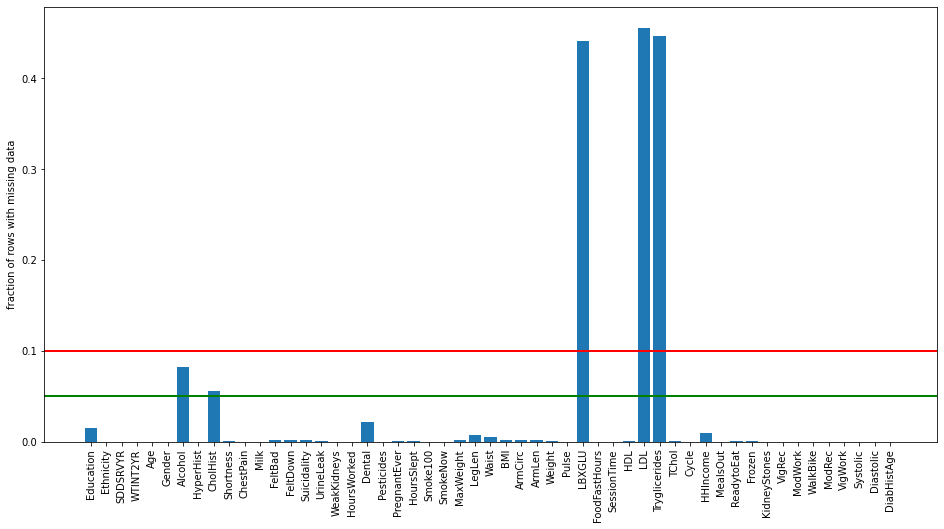

In [14]:
column_fraction_null = col_frac_missing(df_depleted)

## Finally we save the data

Most of the columns have low numbers of missing values, aside from the laboratory data, which we keep only to study in the EDA, not for the purpose of predictive analysis.

In [15]:
df_depleted.to_pickle("wrangled_data.pkl")